# A typical driver for climate runs

In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib as mpl

from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.util.plot_base import PlotBase

In [2]:
myplt = PlotBase(palette='ipcc_wg1')

In [3]:
# Definitions of MCE variables and parameters
with open('mce/core/attributes.yml') as f1:
    mce_attrs = yaml.safe_load(f1)

In [4]:
list(mce_attrs)

['variables', 'parameters']

## Example scenarios

In [5]:
class ScenarioCmipDeck(ScenarioBase):
    def init_process(self, cco2_pi, **kw):
        """Define abrupt-4xCO2 and 1pctCO2 of CMIP DECK
        """
        grp = self.file.create_group('abrupt-4xCO2')
        time = np.hstack([0., np.arange(150) + 0.5])
        dset = grp.create_dataset('input/conc/time', data=time)
        dset.attrs['units'] = 'yr'
        cco2 = np.zeros(len(time)) + 4 * cco2_pi
        dset = grp.create_dataset('input/conc/CO2', data=cco2)
        dset.attrs['units'] = 'ppm'

        grp = self.file.create_group('1pctCO2')
        time = np.hstack([0., np.arange(140) + 0.5])
        dset = grp.create_dataset('input/conc/time', data=time)
        dset.attrs['units'] = 'yr'
        cco2 = cco2_pi * 1.01**time
        dset = grp.create_dataset('input/conc/CO2', data=cco2)
        dset.attrs['units'] = 'ppm'

In [6]:
ds = ScenarioCmipDeck(280.)

[2025-03-20 10:54:40 mce.core] INFO:in-memory file opened


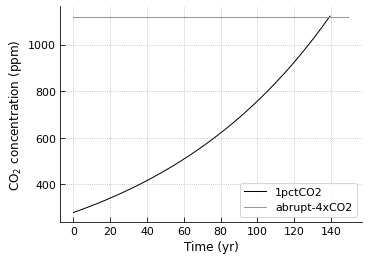

In [7]:
myplt.init_regular()
ax = myplt(0)

for name, grp in ds.file.items():
    gin = grp['input/conc']
    ax.plot(gin['time'][:], gin['CO2'][:], label=name)

ax.legend()
ax.set_ylabel('CO$_2$ concentration (ppm)')
ax.set_xlabel('Time (yr)')
ax.grid()

## Driver for climate runs

In [8]:
class DriverClimate(DriverBase):
    def erf_in(self, t, y):
        """Evaluate forcing based on a given scenario

        Parameters
        ----------
        t
            Time point in year
        y
            Value of each prediction variable at the time point

        Returns
        -------
            Forcing in W m-2 at the time point
        """
        din = self.din['conc']
        cco2 = din['interp'](t)[0]

        return self.forcing.c2erf(cco2)

## Conduct climate runs

In [9]:
config = {'climate': {}}
drv = DriverClimate(**config)

In [10]:
for name in ds():
    din = ds.get_scenario(name)
    time = din['conc']['time']
    ret = drv.run(din, time)

    gout = ds.file.create_group(f'{name}/output')

    for vn, d1 in ret.items():
        dset = gout.create_dataset(vn, data=d1)
        for k, v in mce_attrs['variables'].get(vn, {}).items():
            dset.attrs[k] = v

In [11]:
list(gout)

['tas', 'thc', 'time']

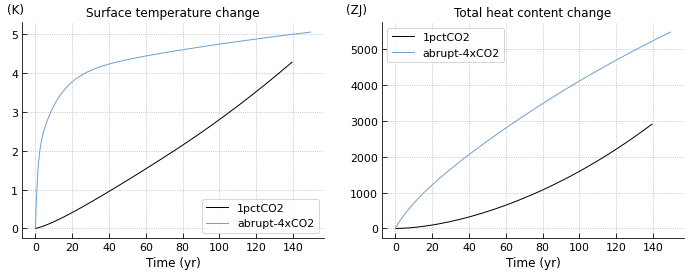

In [12]:
myplt.init_regular(2, col=2)

kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}

for ax, vn in zip(myplt(), ['tas', 'thc']):
    attrs = mce_attrs['variables'][vn]

    for name, grp in ds.file.items():
        gout = grp['output']
        ax.plot(
            gout['time'][:],
            gout[vn][:],
            label=name,
        )

    ax.legend()
    ax.set_title(attrs['long_name'])
    ax.set_ylabel('({})'.format(attrs['units']), **kw_ylabel)
    ax.set_xlabel('Time (yr)')
    ax.grid()

In [13]:
ds.close()

[2025-03-20 10:54:42 mce.core] INFO:in-memory file closed
